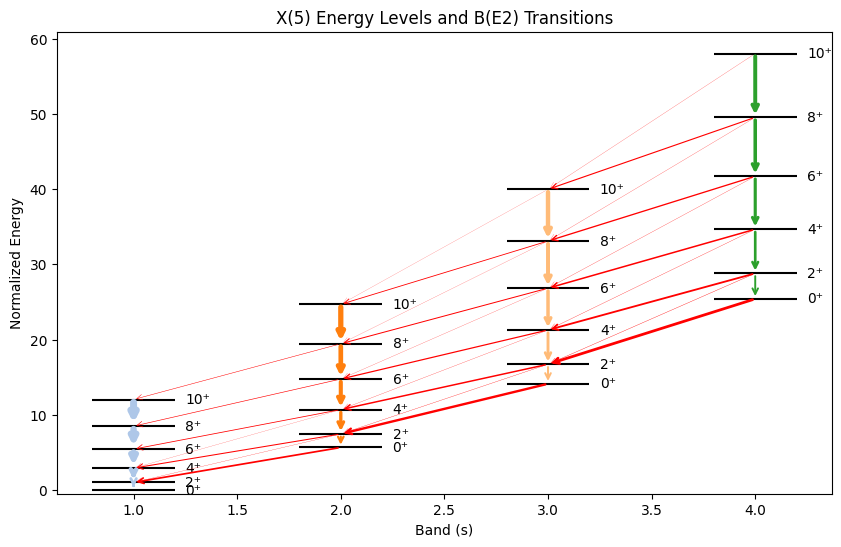

In [6]:
import numpy as np
from scipy.special import jv
from scipy.integrate import quad
from sympy.physics.wigner import clebsch_gordan
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ---------- Utilities ----------

def first_bessel_zero(nu, s=1, x_min=0.1, x_max=50.0):
    def f(x):
        return jv(nu, x)
    zeros = []
    x_left = x_min
    step = 0.1
    while x_left < x_max and len(zeros) < s:
        x_right = x_left + step
        if f(x_left) * f(x_right) < 0:
            zeros.append(brentq(f, x_left, x_right))
        x_left = x_right
    if len(zeros) < s:
        raise RuntimeError(f"Less than {s} zeros found for J_{nu}(x)")
    return zeros[s - 1]

def normalization_constant(nu, zero):
    return 0.5 * (jv(nu + 1, zero)) ** 2

def radial_wavefunction(beta, nu, zero, norm_const):
    return beta**(-1.5) * jv(nu, zero * beta) / np.sqrt(norm_const)

def radial_integral_general(s1, L1, s2, L2, zeros):
    nu1 = np.sqrt(L1 * (L1 + 1) / 3 + 9 / 4)
    zero1 = zeros[(s1, L1)]
    C1 = normalization_constant(nu1, zero1)

    nu2 = np.sqrt(L2 * (L2 + 1) / 3 + 9 / 4)
    zero2 = zeros[(s2, L2)]
    C2 = normalization_constant(nu2, zero2)

    def integrand(beta):
        psi1 = radial_wavefunction(beta, nu1, zero1, C1)
        psi2 = radial_wavefunction(beta, nu2, zero2, C2)
        return psi1 * psi2 * beta**5

    result, _ = quad(integrand, 0, 1, limit=200, epsabs=1e-10)
    return result**2

def cg_squared(L1, L2):
    return float(clebsch_gordan(L2, 2, L1, 0, 0, 0).evalf()) ** 2

def alaga_prefactor(L1, L2):
    return (2 * L2 + 1) / (2 * L1 + 1)

def radial_integral_intra(L, zeros, s=1):
    return radial_integral_general(s, L, s, L - 2, zeros)

# ---------- Energy Levels ----------

def energy_levels(max_s, L_max):
    levels = {}
    zeros = {}
    for s in range(1, max_s + 1):
        for L in range(0, L_max + 2, 2):
            nu = np.sqrt(L * (L + 1) / 3 + 9 / 4)
            zero = first_bessel_zero(nu, s)
            levels[(s, L)] = zero**2
            zeros[(s, L)] = zero
    E0 = levels[(1, 0)]
    E2 = levels[(1, 2)]
    norm_levels = {(s, L): (levels[(s, L)] - E0) / (E2 - E0) for (s, L) in levels}
    return norm_levels, zeros

# ---------- B(E2) with Scaling ----------

def compute_b2_scaled(zeros, L_max, s=1, ref_points=None, normalize_first_transition=None):
    raw_be2 = {}
    for L in range(2, L_max + 2, 2):
        I2 = radial_integral_intra(L, zeros, s)
        CG2 = cg_squared(L, L - 2)
        A = alaga_prefactor(L, L - 2)
        raw_be2[(L, L - 2)] = I2 * CG2 * A
    if ref_points:
        calc_vals = [raw_be2[k] for k in ref_points]
        target_vals = [ref_points[k] for k in ref_points]
        interp_func = interp1d(calc_vals, target_vals, fill_value='extrapolate', kind='linear')
        scaled_be2 = {k: float(interp_func(v)) for k, v in raw_be2.items()}
    elif normalize_first_transition:
        target_val = normalize_first_transition
        first_key = (2, 0)
        scale_factor = target_val / raw_be2[first_key]
        scaled_be2 = {k: v * scale_factor for k, v in raw_be2.items()}
    else:
        scaled_be2 = raw_be2
    return scaled_be2

def compute_inter_band_fixed_refs(zeros, L_max, s1, s2, ref_points):
    inter_be2 = {}
    raw_vals = {}
    for L1 in range(0, L_max + 2, 2):
        for delta_L in [-2, 0, 2]:
            L2 = L1 + delta_L
            if L2 < 0 or L2 > L_max + 1:
                continue
            if (s1, L1) not in zeros or (s2, L2) not in zeros:
                continue
            if L1 == 0 and L2 == 0:
                continue
            I2 = radial_integral_general(s1, L1, s2, L2, zeros)
            CG2 = cg_squared(L1, L2)
            A = alaga_prefactor(L1, L2)
            be2 = I2 * CG2 * A
            raw_vals[(L1, L2)] = be2
    calc_vals = [raw_vals[k] for k in ref_points]
    target_vals = [ref_points[k] for k in ref_points]
    interp_func = interp1d(calc_vals, target_vals, fill_value='extrapolate', kind='linear')
    for (L1, L2), raw in raw_vals.items():
        if (L1, L2) in ref_points:
            inter_be2[(L1, L2)] = ref_points[(L1, L2)]
        else:
            inter_be2[(L1, L2)] = float(interp_func(raw))
    return inter_be2

# ---------- Plot Energy Level Scheme with Transitions ----------

def plot_level_scheme(energies, intra_band_be2, inter_band_be2_list, threshold):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20.colors

    for (s, L), E in energies.items():
        ax.hlines(E, s - 0.2, s + 0.2, colors='black')
        ax.text(s + 0.25, E, f"{L}⁺", va='center')

    for s, be2 in intra_band_be2.items():
        for (L1, L2), val in be2.items():
            if val >= threshold:
                x = s
                y1 = energies[(s, L1)]
                y2 = energies[(s, L2)]
                ax.annotate("", xy=(x, y2), xytext=(x, y1),
                            arrowprops=dict(arrowstyle="->", color=colors[s % len(colors)],
                                            lw=val/50))

    for (s1, s2, be2) in inter_band_be2_list:
        for (L1, L2), val in be2.items():
            if val >= threshold:
                x1, x2 = s1, s2
                y1 = energies[(s1, L1)]
                y2 = energies[(s2, L2)]
                if y1 <= y2:
                    continue
                ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                            arrowprops=dict(arrowstyle="->", color='red', lw=val/50))

    ax.set_xlabel("Band (s)")
    ax.set_ylabel("Normalized Energy")
    ax.set_title("X(5) Energy Levels and B(E2) Transitions")
    ax.set_ylim(bottom=-0.5)
    plt.show()

# ---------- Main Program ----------

if __name__ == "__main__":
    try:
        L_max = int(input("Enter highest even L (e.g., 10): "))
        max_s = int(input("Enter number of bands s (e.g., 4): "))
        threshold = float(input("Enter B(E2) threshold for plotting transitions: "))

        energies, zeros = energy_levels(max_s, L_max)

        intra_refs = {
            1: {(2, 0): 100, (4, 2): 160, (6, 4): 198, (8, 6): 228, (10, 8): 251},
            2: {(2, 0): 80, (4, 2): 120, (6, 4): 147, (8, 6): 169, (10, 8): 189},
            3: {(2, 0): 73, (4, 2): 104, (6, 4): 125, (8, 6): 143},
            4: {(2, 0): 69, (4, 2): 96}
        }

        intra_band_be2 = {}
        for s in range(1, max_s + 1):
            be2 = compute_b2_scaled(zeros, L_max, s=s, ref_points=intra_refs.get(s))
            intra_band_be2[s] = be2

        inter_band_be2_list = []

        ref_21 = {(0, 2): 62, (2, 0): 2.1, (2, 2): 8.2, (4, 2): 0.9, (2, 4): 37, (4, 4): 6.1, (6, 4): 0.6, (4, 6): 28, (6, 6): 4.9, (6, 8): 22}
        inter_band_be2_list.append((2, 1, compute_inter_band_fixed_refs(zeros, L_max, 2, 1, ref_21)))

        ref_31 = {(0, 2): 0.6, (2, 0): 0.5, (2, 2): 1.0, (4, 2): 0.8, (2, 4): 2.0, (4, 4): 1.7, (6, 4): 1.5, (4, 6): 3.2, (6, 6): 2.8, (6, 8): 4.5}
        inter_band_be2_list.append((3, 1, compute_inter_band_fixed_refs(zeros, L_max, 3, 1, ref_31)))

        ref_32 = {(0, 2): 86, (2, 0): 2.7, (2, 2): 11, (2, 4): 54}
        inter_band_be2_list.append((3, 2, compute_inter_band_fixed_refs(zeros, L_max, 3, 2, ref_32)))

        ref_43 = {(0, 2): 99, (2, 0): 2.8, (2, 2): 13, (2, 4): 66}
        inter_band_be2_list.append((4, 3, compute_inter_band_fixed_refs(zeros, L_max, 4, 3, ref_43)))

        ref_42 = {(0, 2): 0.6, (2, 0): 0.5, (2, 2): 1.0, (4, 2): 0.8, (2, 4): 2.0, (4, 4): 1.7, (6, 4): 1.5, (4, 6): 3.2, (6, 6): 2.8, (6, 8): 4.5}
        inter_band_be2_list.append((4, 2, compute_inter_band_fixed_refs(zeros, L_max, 4, 2, ref_42)))

        ref_41 = {(0, 2): 0.2, (2, 0): 0.1, (2, 2): 0.4, (4, 2): 0.3, (2, 4): 0.7, (4, 4): 0.6, (6, 4): 0.5, (4, 6): 0.9, (6, 6): 0.8, (6, 8): 1.4}
        inter_band_be2_list.append((4, 1, compute_inter_band_fixed_refs(zeros, L_max, 4, 1, ref_41)))

        plot_level_scheme(energies, intra_band_be2, inter_band_be2_list, threshold)

    except Exception as e:
        print("Error:", e)
